## Introduction to Stan via linear regression

In this notebook we will use a simple example of single-variable linear regression to demonstrate the basic structure of a Stan program, how it is called, and how to plot the results Stan yields.

First we load Stan and tell Stan to look for and use multiple processors, if available.

In [2]:
library(rstan)
options(mc.cores = parallel::detectCores())

The code below generates a synthetic dataset of length 100, with slope of 1.5, instercept of 2, and a noise error standard deviation of 1.25.
$x$ is the independent variable and $y$ is the dependent variable.

In [3]:
N     <- 100
beta1 <- 1.5
beta0 <- 2
sigma <- 1.25

x <- rnorm(N)
y <- beta0 + beta1*x + rnorm(N,mean=0,sd=sigma)

We plot the data

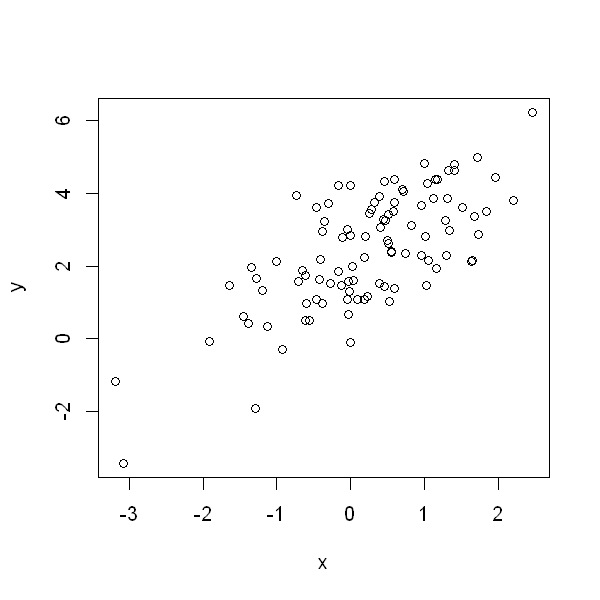

In [4]:
options(repr.plot.width=5, repr.plot.height=5)
plot(x,y)

The code below is our first Stan program. 
There are several ways to pass Stan code to the Stan program.
Here we are using character strings to easily integrate with a standalone notebook.

Stan programs are structured as templated blocks. 

#### `data` block
We pass the data and all inputs in the `data` block. 
In this case Stan needs the vectors $x$ and $y$ and the length of those vectors $N$.

#### `parameter` block
We tell Stan which unknown parameters we seek to estimate via the `parameters` block.
We will estimate the intercept `beta0`, the slope `beta1` and the error standard devation `sigma`.
We give `sigma` a lower bound of a very small positive number to tell Stan not to try fitting with a standard deviation less than or equal to zero because it doesn't make mathemtical sense and Stan will get angry.

#### `model` block
The `model` block contains two components (despite it only being one block): the prior and likelihood.
This is where we tell Stan about the probability distributions being used in the problem.
You can tell the prior and likelihood apart in that the prior will not use the data, while the likelihood will. 
The likelihood will describe the distribution of the data *conditional on the parameters*.
Here we assign normal distributions with mean zero and standard deviation 100 to `beta0` and `beta1`.
We assign a normal distribution to the data with mean `beta0 + beta1*x` and standard deviation `sigma`.

In [5]:
stancode <- "
data {
    int       N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real              beta0;
    real              beta1;
    real<lower=1E-15> sigma;
}
model{
    // Priors
    beta0 ~ normal(0,100);
    beta1 ~ normal(0,100);
    
    // Likelihood
    y ~ normal(beta0 + beta1*x, sigma);
}"

We compile the Stan code via RStan below.

In [6]:
mod <- stan_model(model_code=stancode)

We organize the data as an R list to pass to Stan

In [7]:
data <- list(N=N,x=x,y=y)

We use the `sampling` command in RStan to perform the MCMC. 
The first argument is the compiled model object, second the data, then we tell how many chains to use and iterations to take.
The final argument tells Stan to open a progress bar in a new window to monitor the MCMC progress. 
I don't know if this argument exists for PyStan and Stan.jl.

In [8]:
mcmc <- sampling(mod, data=data, chains=4, iter=2000, open_progress=TRUE)

We look at the summary table for the mcmc results.

In [9]:
mcmc

Inference for Stan model: 91424571a1d7b0c5c128fe7ad64dceff.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
beta0   2.19    0.00 0.12   1.97   2.12   2.19   2.27   2.43  2714    1
beta1   1.08    0.00 0.11   0.86   1.01   1.09   1.16   1.29  3702    1
sigma   1.13    0.00 0.08   0.98   1.08   1.13   1.19   1.31  3273    1
lp__  -61.70    0.03 1.28 -65.00 -62.23 -61.35 -60.78 -60.28  1869    1

Samples were drawn using NUTS(diag_e) at Sat Jan 04 09:34:11 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

(See slides for a description of `n_eff` and `Rhat` diagnostics)

We extract the mcmc samples below.

In [10]:
post <- extract(mcmc)

Now `post` is a list of variables, each containing the full set of mcmc samples.
Each variable is given as a matrix or vector, depending on the dimension of the variable.
If multivariate, the matrix columns will give each individual element.

In [11]:
names(post)

[1] "beta0" "beta1" "sigma" "lp__"

The order of the mcmc samples represents the order in which they were sampled. 
This means you can plot the mcmc samples as a sequence to see the trajectory of the sampler.

You can compare the appearance of this mcmc trajectory to that of the random walk MH algorithm. 
In this case the samples are uncorrelated so each sample contributes much more information that the strongly correlated sample characteristic of RWMH.

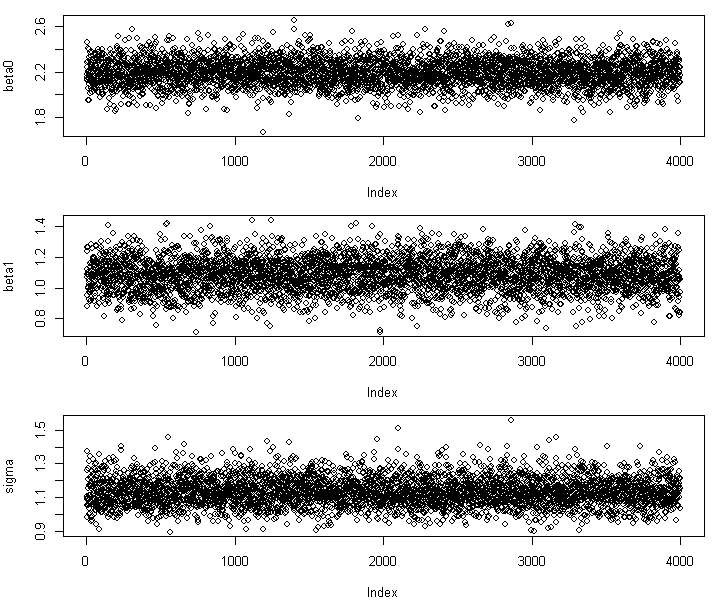

In [12]:
options(repr.plot.width=6, repr.plot.height=5)
par(mfrow=c(3,1),mar=c(4,4,1,1))
plot(post$beta0,ylab='beta0')
plot(post$beta1,ylab='beta1')
plot(post$sigma,ylab='sigma')

Below we ignore the sequence and plot the distribution as a histogram.
These plots represent the marginal distribution of each parameter after integrating (via mcmc) over the distribution of the other variables. 

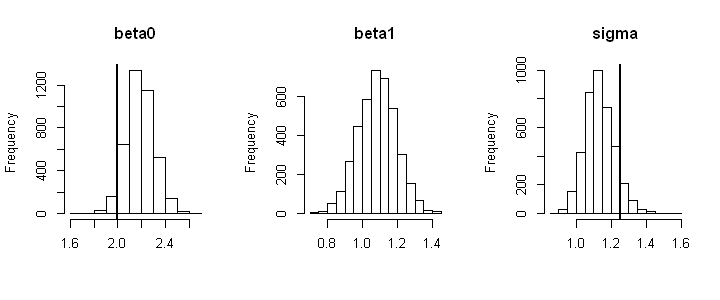

In [13]:
options(repr.plot.width=6, repr.plot.height=2.5)
par(mfrow=c(1,3))
hist(post$beta0,main='beta0',xlab='')
    abline(v=beta0,lwd=2)
hist(post$beta1,main='beta1',xlab='')
    abline(v=beta1,lwd=2)
hist(post$sigma,main='sigma',xlab='')
    abline(v=sigma,lwd=2)

Below we randomly sample the mcmc samples to plot some lines.
Since the order of the samples represents the mcmc steps, we want to pair the same sample numbers in order to get a proper sample from the joint posterior.

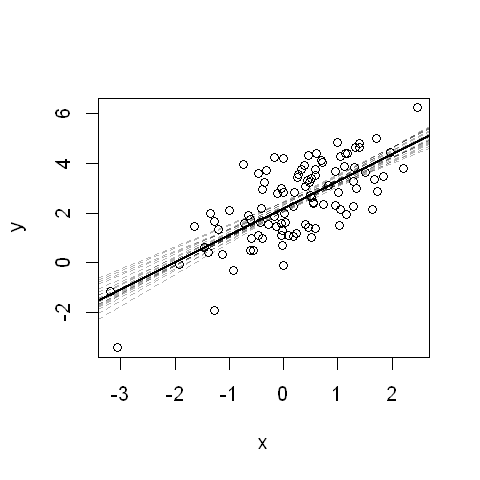

In [15]:
options(repr.plot.width=4, repr.plot.height=4)
plot(x,y)
abline(mean(post$beta0), mean(post$beta1),lwd=2)
for(i in sample(1:length(post$beta0),20)){
    abline(post$beta0[i],post$beta1[i],lty=2,col=adjustcolor('black',alpha.f=0.3))
}

Previously we gave very wide normal distributions which is effectively *un*informative in the sense that the solution is indistinguishable had we given the uniform priors.

EXERCISE IDEA: try imposing a uniform prior in the above and compare the fits.

Below we demonstrate the effect of *informative* prior distributions. 
We give the prior distribution on the slope a normal distribution with mean 2.5 and standard deviation of 0.1.

For example, this prior may have come from analysis of previous data. 
The Bayesian solution has a nice property that we would get the same answer when we use a previous posterior as a prior, vs. if we pooled all the data and analyzed them together.

In [85]:
stancode_prior <- "
data {
    int       N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real              beta0;
    real              beta1;
    real<lower=1E-15> sigma;
}
model{
    // Priors
    beta0 ~ normal(0,100);
    beta1 ~ normal(2.5,0.1);
    
    // Likelihood
    y ~ normal(beta0 + beta1*x, sigma);
}"

We plot the prior

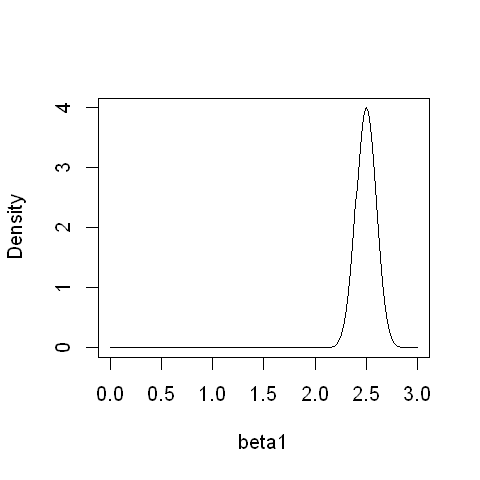

In [86]:
xin <- seq(0,3,0.01)
plot(xin,dnorm(xin,mean=2.5,sd=0.1),type='l',xlab='beta1',ylab='Density')

Compile the new Stan program.

In [87]:
mod_prior <- stan_model(model_code=stancode_prior)

Sample from the posterior

In [91]:
mcmc_prior <- sampling(mod_prior, data=data, chains=4, iter=2000, open_progress=TRUE)

In [16]:
mcmc_prior

ERROR: Error in eval(expr, envir, enclos): object 'mcmc_prior' not found


In [93]:
post_prior <- extract(mcmc_prior)

Plot the posterior relative to the prior.
Note the increased error due to the prior constraints.

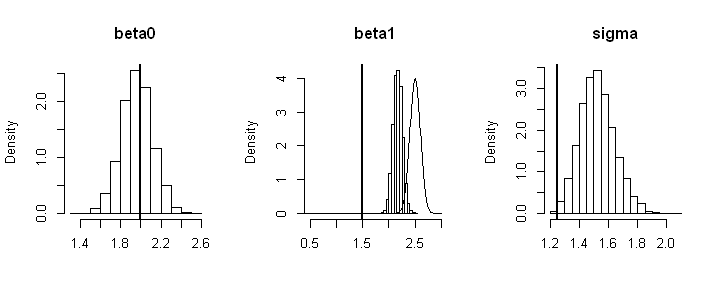

In [99]:
options(repr.plot.width=6, repr.plot.height=2.5)
par(mfrow=c(1,3))
hist(post_prior$beta0,main='beta0',xlab='',freq=FALSE)
    abline(v=beta0,lwd=2)
hist(post_prior$beta1,main='beta1',xlab='',xlim=c(0.5,3),freq=FALSE)
    abline(v=beta1,lwd=2)
    lines(xin,dnorm(xin,mean=2.5,sd=0.1))
hist(post_prior$sigma,main='sigma',xlab='',freq=FALSE)
    abline(v=sigma,lwd=2)